# EDA

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
hotel_info = pd.read_csv("hotels-50k/dataset/hotel_info.csv")
print("Number of unique hotels:", hotel_info["hotel_id"].nunique())
hotel_info.head()

Number of unique hotels: 50000


,hotel_id,hotel_name,chain_id,latitude,longitude
0,391,Extended Stay America - Fairbanks - Old Airpor...,72,64.83538,-147.82330
1,392,Hilton Hangzhou Qiandao Lake Resort,3,29.60819,119.07290
2,393,Taj Lands End,-1,19.04391,72.81879
3,395,Cambridge Suites Hotel Sydney,-1,46.13663,-60.19551
4,396,Tamanu Beach,14,-18.84213,-159.78794


In [3]:
chain_info = pd.read_csv("hotels-50k/dataset/chain_info.csv")
print("Number of hotel chains:", chain_info["chain_id"].nunique())
chain_info.head()

Number of hotel chains: 93


,chain_id,chain_name
0,-1,unknown
1,0,Best Western
2,1,Hyatt
3,2,Marriott
4,3,Hilton


In [4]:
test_set = pd.read_csv("hotels-50k/dataset/test_set.csv", header=0)
train_set = pd.read_csv("hotels-50k/dataset/train_set.csv", header=None)
train_set.columns = test_set.columns

In [5]:
print("Total train observations:", train_set.shape[0])
print("Total test observations:", test_set.shape[0])

Total train observations: 1124215
Total test observations: 16171


In [6]:
train_set["image_source"].value_counts()

travel_website    1079585
traffickcam         44630
Name: image_source, dtype: int64

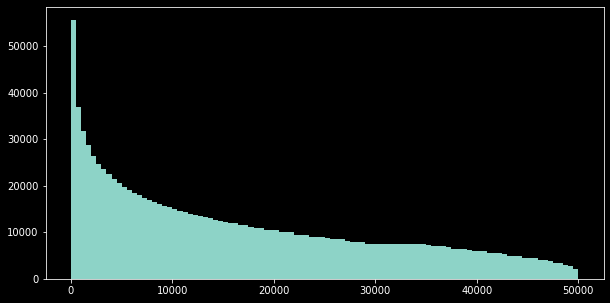

In [7]:
values, counts = np.unique(train_set["hotel_id"], return_counts=True)
to_hist = train_set["hotel_id"].map(dict(zip(values[np.argsort(-counts)], range(50000))))
plt.figure(figsize=(10, 5))
plt.hist(to_hist, bins=100);

In [8]:
chain_mapping = dict(zip(hotel_info["hotel_id"], hotel_info["chain_id"]))
train_set["chain_id"] = train_set["hotel_id"].map(chain_mapping)

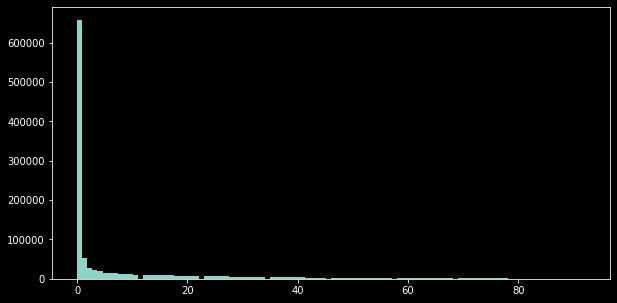

In [9]:
values, counts = np.unique(train_set["chain_id"], return_counts=True)
to_hist = train_set["chain_id"].map(dict(zip(values[np.argsort(-counts)], range(len(counts)))))
plt.figure(figsize=(10, 5))
plt.hist(to_hist, bins=100);

## Captioning

In [10]:
import warnings
import requests
import os
from PIL import Image

In [11]:
def get_image_path(url, dir):
    return dir + url[8:].replace("/", "_")

def download_image(url, dir="./"):
    path = get_image_path(url, dir)
    if not os.path.exists(path):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            response = requests.get(url, verify=False)
        with open(path, 'wb') as f:
            f.write(response.content)
    try:
        return Image.open(path)
    except Image.UnidentifiedImageError:
        return None

def image_is_opening(url, dir):
    return download_image(url, dir) is not None

Скачаем изображения. Так как их слишком много, возьмем семпл в 1/1000. Это не самый честный семпл, так как не берутся в расчет авторы изображений и баланс классов.

In [12]:
train_set["image_path"] = train_set["image_url"].map(lambda x: get_image_path(x, dir="./images/"))

In [13]:
sample_count = round(train_set.shape[0] * 1 / 1000)
train_set_sample = train_set.sample(sample_count, random_state=1)

Много фото не скачиваются, таких около 20%. Только 882 из 1124 - корректные изображения.

In [14]:
non_broken_images = [image_is_opening(url, dir="./images/") for url in train_set_sample["image_url"]]
train_set_sample = train_set_sample.iloc[non_broken_images]

In [15]:
width = []
height = []
for x in train_set_sample["image_path"]:
    img = Image.open(x)
    width.append(img.size[0])
    height.append(img.size[1])
train_set_sample["width"] = width
train_set_sample["height"] = height

Медианный размер картинок - 350 х 233, фотографии из TrafficCam - в основном фото с фотоаппаратов в большом разрешении.

In [16]:
train_set_sample["width"].median(), train_set_sample["height"].median()

(350.0, 233.0)

In [18]:
from datasets import Dataset

dataset = Dataset.from_pandas(train_set_sample)
dataset = dataset.map(lambda example: {'image_': download_image(example['image_url'], dir="./images/"), 'image': example['image_path']})

Map:   0%|          | 0/882 [00:00<?, ? examples/s]

In [19]:
from transformers import pipeline

model = "Salesforce/blip-image-captioning-large"

def gen(iterable):
    for x in iterable:
        yield Image.open(x)

captioner = pipeline("image-to-text", model=model, device="cuda:0")
ans = []
for out in captioner(gen(dataset['image']), max_new_tokens=100, batch_size=16):
    ans.append(out)
ans_join = [" ".join(x["generated_text"] for x in y if x["generated_text"]) for y in ans]
train_set_sample["caption"] = ans_join

In [20]:
train_set_sample["caption"]

43240     there is a bathroom with a sink and a mirror i...
748652    there is a bathroom with a balcony and a sink ...
988080    a ##raf ##ed bedroom with a bed and a painting...
643100    there is a bed with a white comfort ##er and a...
306553    there is a bed with a red and gold beds ##pre ...
                                ...                        
853689    lobby area with seating and fireplace in hotel...
805457        bunk beds in a room with a chair and a window
252295    there is a bed with two beds in a room with a ...
263157       there is a small bedroom with a bed and a desk
621350     there is a tray of food on a bed in a hotel room
Name: caption, Length: 882, dtype: object

Описания получились не очень информативными, чаще всего это просто комната с кроватью.

Наверное, инопланетянам это не очень поможет, но с другой стороны а что им может пригодиться, кроме картинок?

# Clustering

In [21]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

Сделаем самый простой метод - просто бинарный вектор из словаря, который использовался моделью. можно было бы еще TF-IDF.

In [22]:
data = np.asarray(CountVectorizer().fit_transform(ans_join).todense()).astype(bool).astype(int)

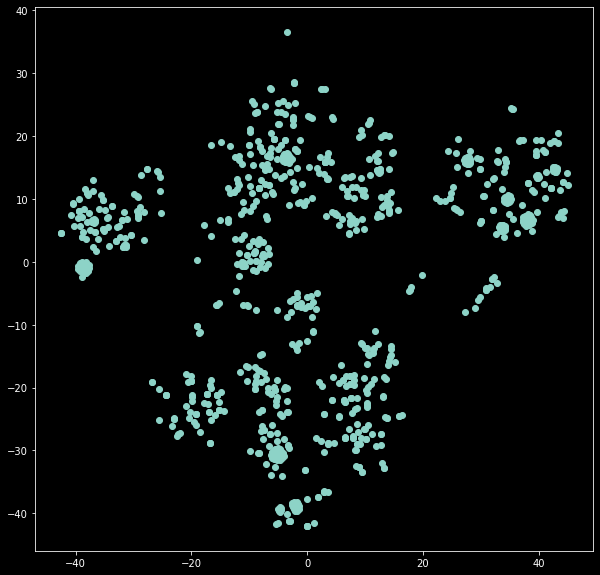

In [23]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    tsne = TSNE(n_components=2, random_state=1)
    data_2d = tsne.fit_transform(data)
plt.figure(figsize=(10, 10))
plt.scatter(*data_2d.T);

Получается примерно 7 кластеров, давайте сделаем K-Means.

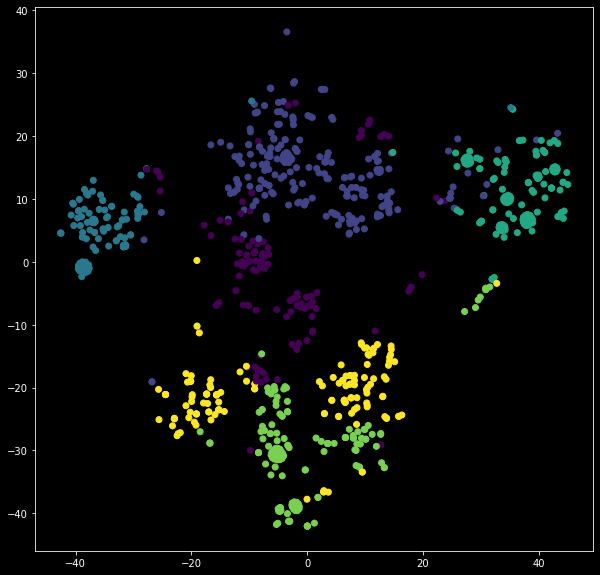

In [24]:
kmeans = KMeans(n_clusters=6, random_state=1)
clusters = kmeans.fit_predict(data)
train_set_sample["cluster"] = clusters
plt.figure(figsize=(10, 10))
plt.scatter(*data_2d.T, c=clusters);

In [25]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

def print_cluster_examples(dataset, cluster=1, dir="./"):
    cluster_data = dataset.loc[dataset["cluster"] == cluster, ["image_url", "caption"]].sample(8)

    def prepare_image(x):
        image = download_image(x, dir="./images/")

        size = 350, 233
        width, height = image.size

        min_side = min(width, height)

        left = (width - min_side) / 2
        top = (height - min_side) / 2
        right = (width + min_side) / 2
        bottom = (height + min_side) / 2

        cropped_image = image.crop((left, top, right, bottom))
        return cropped_image.resize(size)
    
    images = [prepare_image(x) for x in cluster_data["image_url"]]
    return image_grid(images, rows=2, cols=4), cluster_data["caption"].tolist()

Можем посмотреть на картинки по кластерам.

there is a coffee table with a tray of food on it
nighttime view of a pool and lounge chairs in a resort
there is a living room with a couch , table , and chairs
there is a small kitchen with a small refrigerator and a small table
tables and chairs in a courtyard with a wall and trees
a ##raf ##ed living room with a couch , chair , table , and a television
there are four cups of juice sitting on a counter next to a flower
a close up of a gaze ##bo in a garden with trees and bushes


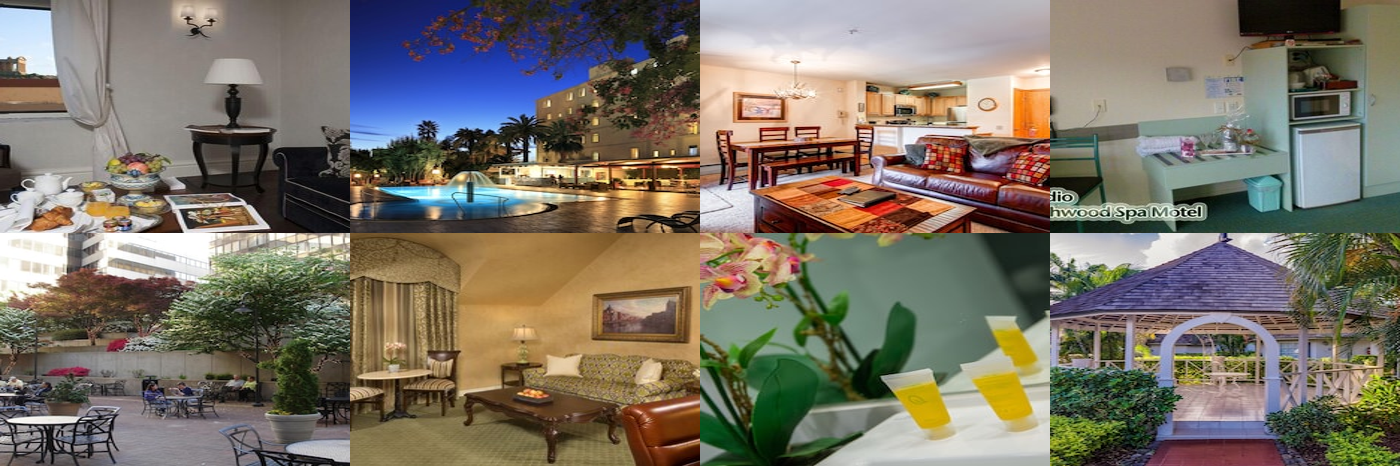

In [36]:
images, captions = print_cluster_examples(train_set_sample, cluster=0, dir="./images/")
print("\n".join(captions))
images

Кластеры конечно не относятся к классам (отелям или сетям отелей), но в них все равно что-то есть полезного.

0. Misc, не самые очевидные изображения каких-то деталей
1. Одна большая двухместная кровать
2. На фото чего-то два - две кровати, два кресла, две раковины и т.д.
3. Фото уборной
4. Просто фото комнаты
5. "rafed" bedroom, что бы это не значило